(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Analyzing Hotel Ratings on Tripadvisor

In this homework we will focus on practicing two techniques: web scraping and regression. For the first part, we will get some basic information for each hotel in Boston. Then, we will fit a regression model on this information and try to analyze it.

** Task 1 (30 pts)**

We will scrape the data using Beautiful Soup. For each hotel that our search returns, we will get the information below.

![Information to be scraped](hotel_info.png)

Of course, feel free to collect even more data if you want. 

In [1]:
from BeautifulSoup import BeautifulSoup
import requests

def download_html(url):
    headers = { 'User-Agent' : "Mozilla/5.0 (Macintosh; Intel Mac " + \
                "OS X 10_10_2) AppleWebKit/537.36 (KHTML, like Gecko)" + \
               "Chrome/41.0.2272.76 Safari/537.36" }
    response = requests.get(url, headers=headers)
    html = response.text.encode('utf-8')
    return html

def extract_hotel_data():
    base_url = 'https://www.tripadvisor.com'
    params = '/Hotels-g60745-Boston_Massachusetts-Hotels.html'
    hotels = {}
    while True:
        html = download_html(base_url + params)
        soup = BeautifulSoup(html)
        next_page = soup.find("div", {"class" : "unified pagination standard_pagination"})
        hotel_boxes = soup.findAll('div', {'class' :'listing easyClear  p13n_imperfect '})
        for hotel_box in hotel_boxes:
            name = hotel_box.find('div', {'class' :'listing_title'}).find(text=True)
            url =  base_url + hotel_box.findAll('a', href= True)[0]['href']
            hotels[name] = url
        if next_page.find('span', {'class' : 'nav next ui_button disabled'}):
            break
        else:
            hrefs = next_page.findAll('a', href=True)
            for href in hrefs:
                if href.find(text = True) == 'Next':
                    params = href['href']
                    break
    review_data = load_and_parse_data()
    for hotel in hotels:
        if hotel in review_data:
            hotel_data = get_hotel_attribs(hotels[hotel])
            for key in hotel_data:
                review_data[hotel][key] = hotel_data[key]
    return review_data

def load_and_parse_data():
    fname = 'rating-summary.dat'
    data = [row.split(':') for row in open(fname, 'r').read().split('\n') if row != '']
    
    def new_hotel():
        return {'Service': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 
                'Cleanliness': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
                'Business service (e.g., internet access)': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
                'Check in / front desk': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
                'Value': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
                'Sleep Quality': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
                'Rooms': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
                'Location': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}}
    
    hotels = dict()
    for entry in data:
        hotel, cat, rating, count = entry[0], entry[1], int(entry[2]), int(entry[3])
        if hotel not in hotels:
            hotels[hotel] = dict()
            hotels[hotel]['Attribute'] = new_hotel()
        hotels[hotel]['Attribute'][cat][rating] += count
        
    to_remove = []
    for hotel in hotels:
        for cat in hotels[hotel]['Attribute']:
            ratings = list(hotels[hotel]['Attribute'][cat].keys())
            count = list(hotels[hotel]['Attribute'][cat].values())
            try: # in case hotel has no reviews, avoid division by zero
                avg = sum([ratings[i]*count[i] for i in range(5)])/float(sum(count))
                hotels[hotel]['Attribute'][cat] = avg
            except:
                to_remove.append(hotel)
                break
    
    for hotel in to_remove:
        hotels.pop(hotel)
    
    return hotels

def get_hotel_attribs(url):
    html = download_html(url)
    soup = BeautifulSoup(html)
    data = {"Rating": {}, "Type": {}}
            
    rating_str = "taplc_prodp13n_hr_sur_review_filter_controls_0_filterRating_"
    for i in range(1, 6):
        rating = soup.find("label", {"for" : rating_str + str(i)})
        rating = int(str(rating.findAll("span")[-2]).partition(">")[2].partition("<")[0].replace(",", ""))
        data['Rating'][i] = rating
    
    ratings = list(data['Rating'].keys())
    count = list(data['Rating'].values())
    avg = sum([ratings[i]*count[i] for i in range(5)])/float(sum(count))
    data['Rating']['Average'] = avg
        
    type_str = "taplc_prodp13n_hr_sur_review_filter_controls_0_filterSegment_"
    for typ in ['Family', 'Couples', 'Solo', 'Business', 'Friends']:
        trav_typ = soup.find("label", {"for" : type_str + typ}).find("span")
        trav_typ = int(str(trav_typ).partition("(")[2].partition(")")[0].replace(",", ""))
        data['Type'][typ] = trav_typ
        
    return data
            
data = extract_hotel_data()

** Task 2 (20 pts) **

Now, we will use regression to analyze this information. First, we will fit a linear regression model that predicts the average rating. For example, for the hotel above, the average rating is

$$ \text{AVG_SCORE} = \frac{1*31 + 2*33 + 3*98 + 4*504 + 5*1861}{2527}$$

Use the model to analyze the important factors that decide the $\text{AVG_SCORE}$.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     9428.
Date:                Tue, 29 Mar 2016   Prob (F-statistic):           3.53e-74
Time:                        18:01:53   Log-Likelihood:                 66.122
No. Observations:                  59   AIC:                            -106.2
Df Residuals:                      46   BIC:                            -79.24
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0049      0.131      0.037      0.9

/Users/coreyclemente/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


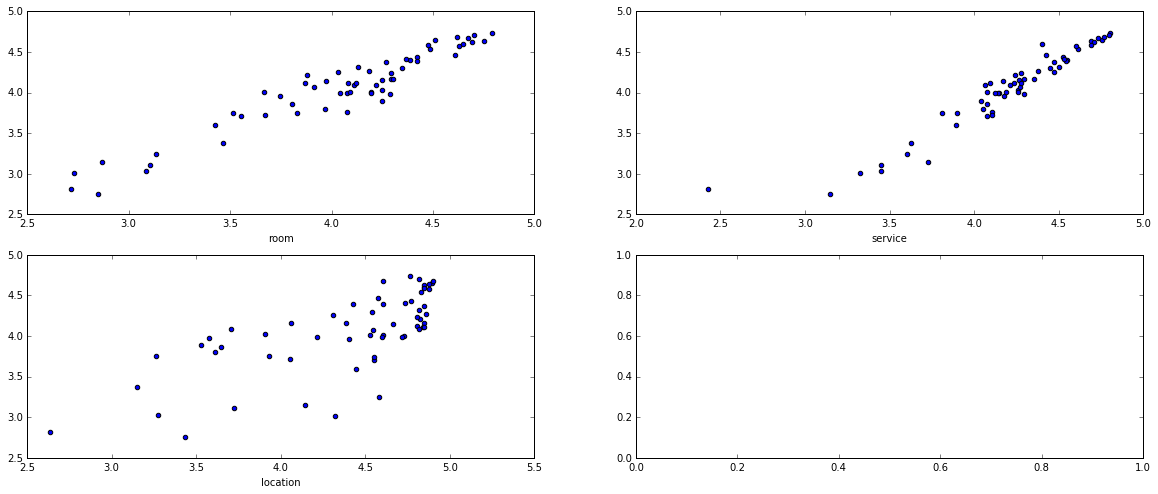

In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
%matplotlib inline

sleep = [data[hotel]['Attribute']['Sleep Quality'] for hotel in data]
rooms = [data[hotel]['Attribute']['Rooms'] for hotel in data]
service = [data[hotel]['Attribute']['Service'] for hotel in data]
cleanliness = [data[hotel]['Attribute']['Cleanliness'] for hotel in data]
business_service = [data[hotel]['Attribute']['Business service (e.g., internet access)'] for hotel in data]
front_desk = [data[hotel]['Attribute']['Check in / front desk'] for hotel in data]
value = [data[hotel]['Attribute']['Value'] for hotel in data]
location = [data[hotel]['Attribute']['Location'] for hotel in data]
couples = [data[hotel]['Type']['Couples'] for hotel in data]
solo = [data[hotel]['Type']['Solo'] for hotel in data]
friends = [data[hotel]['Type']['Friends'] for hotel in data]
business = [data[hotel]['Type']['Business'] for hotel in data]
family = [data[hotel]['Type']['Family'] for hotel in data]

y_lin = np.array([data[hotel]['Rating']['Average'] for hotel in data])
X_lin = np.array([sleep, rooms, service, cleanliness, business_service, front_desk, \
                  value, location, couples, solo, friends, business, family]).T

model = sm.OLS(y_lin, X_lin)
results = model.fit()
print results.summary()

fig, axes = plt.subplots(2, 2, figsize=(20, 8))
indicies = [(0, 0), (0, 1), (1, 0), (0, 1)]
labels = ['room', 'service', 'location']
X_plot = [rooms, service, location]

for i in range(3):
    j, k = indicies[i]
    axes[j][k].scatter(X_plot[i], y_lin)
    axes[j][k].set_xlabel(labels[i])
    fig.show()

MY ANALYSIS:

The three variables (x2, x3, x8) of room quality, service, and location appear to have statistical importance in predicting the overall rating of hotels on TripAdvisor. Since R-Squared is 1 and the F-score is very small, these results are very likely to hold strong accuracy. 

x2 (room quality) holds the smallest p value of 0.000, with the largest coefficient throughout all independent variables. I believe these stats, as the quality of the hotel room is very (or even most) significant when considering how nice a hotel is. 

x8 (location) holds the second smallest p value at 0.001 and the third largest coefficient of 0.14.

x3 (service) holds the fourth smallest p value at 0.031 and the second largest coefficient of 0.14.

These four variables together make a very good predictor for the overall rating of hotels in this dataset. 

** Task 3 (30 pts) **

Finally, we will use logistic regression to decide if a hotel is _excellent_ or not. We classify a hotel as _excellent_ if more than **60%** of its ratings are 5 stars. This is a binary attribute on which we can fit a logistic regression model. As before, use the model to analyze the data.

In [3]:
y_log = np.array([1 if data[hotel]['Rating'][5] >= sum(list(data[hotel]['Rating'].values()))*.6 \
                     else 0 for hotel in data])
X_log = np.array([sleep, rooms, service, cleanliness, business_service, front_desk, \
                  value, location]).T

logit = sm.Logit(y_log, X_log)
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.186547
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   59
Model:                          Logit   Df Residuals:                       51
Method:                           MLE   Df Model:                            7
Date:                Tue, 29 Mar 2016   Pseudo R-squ.:                  0.6595
Time:                        18:01:54   Log-Likelihood:                -11.006
converged:                       True   LL-Null:                       -32.328
                                        LLR p-value:                 3.908e-07
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1           -20.5766     11.521     -1.786      0.074       -43.157     2.004
x2            57.7804     24

MY ANALYSIS:

The two variables (x2, x3) of room quality and service appear to increase the likelihood that a hotel is excellent given an increase in those variables. 

x2 (room quality) holds the smallest p value of 0.018, with the largest coefficient throughout all independent variables.

x3 (service) holds the second smallest p value at 0.035 and the second largest coefficient.

These two variables are believable, where the combination of how good a room is and how good the service is are strong predictors if a hotel is top-tier or not. 

-------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()